Optimisation des Données d'une boutique

L'étude a été effectué pour un marchand de vin prestigieux

Actuellement, pour gérer nos ressources, nos clients, etc., on utilise un ERP qui n’est absolument pas relié à notre site de vente en ligne.

Rapprochement de deux exports :
- un export de l’ERP contenant les références produit, leur prix de vente et leur état de stock
- un export d’une table de l’outil de CMS contenant les informations des produits commercialisés en ligne (nom, description, nombre de ventes...)

Après le rapprochement effectué, nous allons analyser les valeurs extrêmes de prix et détecter d'éventuelles valeurs aberrantes et analyser le chiffre d'affaire.


##  SOMMAIRE

* [1. Préparation des données](#chapter1)
    * [1.1 Importation des librairies Python](#section_1_1)
    * [1.2 Importation des données](#section_1_2)
    * [1.3 Vérification des données](#section_1_3)
        * [1.3.1 Dataframe 'liaison'](#section_1_3_1)
        * [1.3.2 Dataframe 'erp'](#section_1_3_2)
        * [1.3.3 Dataframe 'web'](#section_1_3_3)
    * [1.4 Jointures](#section_1_4)     
* [2. Chiffre d'affaires](#chapter2)
    * [2.1 Chiffre d'affaires par produit](#section_2_1)
    * [2.2 Chiffre d'affaires total](#section_2_2)
* [3. Recherche des valeurs extrêmes 'price'](#chapter3)
    * [3.1 Méthode de l'écart interquartile](#section_3_1)
    * [3.2 Méthode du z-score](#section_3_2)
    * [3.3 Comparaison des 2 méthodes](#section_3_3)
    * [3.4 Vérification des valeurs extrêmes](#section_3_4)

## 1 Préparation des données <a class="anchor" id="#chapter1"></a>

### 1.1 Importation des librairies Python <a class="anchor" id="##section_1_1"></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import scipy.stats as stats

### 1.2 Importation des données <a class="anchor" id="##section_1_2"></a>

Données utilisées:

- Export "ERP" contenant les références produit ('product_id'), leur prix de vente et leur état de stock

- Export "WEB" d’une table de l’outil de CMS contenant les informations des produits commercialisés en ligne ('SKU',nom, description, nombre de ventes...).

- Tableau "Liaison" permettant d’établir le lien entre la référence du produit dans l’ERP (product_id) et la référence du même produit dans la base de la boutique en ligne ('id_web' = 'SKU')


In [2]:
erp = pd.read_excel('erp.xlsx')
web = pd.read_excel('web.xlsx')
liaison = pd.read_excel('liaison.xlsx')

### 1.3 Vérification des données <a class="anchor" id="##section_1_3"></a>

#### 1.3.1 Dataframe 'liaison' <a class="anchor" id="##section_1_3_1"></a>

#####  Changement de nom de colonne

Nous renommons la nom colonne 'id_web' en 'sku'.

In [3]:
liaison = liaison.rename(columns = {'id_web' : 'sku'})

#####  Vérification et Transformation de types de données

In [4]:
liaison.dtypes

product_id     int64
sku           object
dtype: object

Nous vérifions les types de données contenus dans la colonne "sku" et nous modifions ensuite le type de données.

In [5]:
liaison['sku'].unique()

array([15298, 15296, 15300, 19814, 19815, 15303, 14975, 16042, 14980,
       16041, 15269, 14977, 16044, 16043, 16449, 16045, 16030, 13127,
       19816, nan, 16029, 16039, 16318, 16275, 16498, 16320, 16319, 15966,
       15022, 15967, 15490, 16416, 11862, 15444, 15953, 12045, 13074,
       15941, 16069, 13072, 15440, 13435, 13078, 13117, 16296, 16014,
       16462, 16013, 16180, 15676, 16120, 15564, 15675, 15378, 15813,
       13416, 14905, 15767, 16505, 15683, 16504, 15787, 14800, 15353,
       15382, 15339, 11668, 13209, 15341, 13217, 304, 11641, 1662, 1360,
       15648, 1364, 7086, 1366, 15140, 16238, 16237, 15141, 14944, 14941,
       14751, 16093, 15668, 15373, 15375, 14474, 15482, 13453, 15075,
       16124, 15785, 15784, 15786, 14332, 16210, 16211, 16209, 15629,
       15583, 16160, 16166, 15783, 16560, 15747, 15746, 16190, 16189,
       16265, 16191, 16263, 15605, 16529, 15441, 13032, 16256, 16322,
       16295, 15656, 15655, 15415, 15414, 15413, 16023, 16024, 15720,
       1

In [6]:
# Transformation du type de données
liaison['sku'] = liaison['sku'].astype('string')
liaison.dtypes

product_id     int64
sku           string
dtype: object

#####  Vérification des valeurs manquantes

In [7]:
liaison.isnull().sum()

product_id     0
sku           91
dtype: int64

In [8]:
liaison = liaison.dropna(subset=['sku'])
liaison.shape[0]

734

#####  Recherche des doublons 

In [9]:
# Recherche de doublons 'product_id'
liaison['product_id'].duplicated().sum() 

0

In [10]:
# Recherche de doublons 'sku'
liaison['sku'].duplicated().sum() 

0

#### 1.3.2 Dataframe 'erp' <a class="anchor" id="##section_1_3_2"></a>

In [11]:
erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


#### Vérification et Transformation de types de données

In [12]:
erp.dtypes

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object

In [13]:
erp['stock_status'].unique()

array(['outofstock', 'instock'], dtype=object)

In [14]:
erp['stock_status'] = erp['stock_status'].astype('string')
erp.dtypes

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       string
dtype: object

#####  Vérification des valeurs manquantes

In [15]:
erp.shape[0]

825

In [16]:
erp.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

#####  Recherche des doublons 'product_id'

In [17]:
erp.duplicated().sum() 

0

#### 1.3.3 Dataframe 'web' <a class="anchor" id="##section_1_3_3"></a>

In [18]:
web.head()

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


#####  Vérification et Transformation de types de données

In [19]:
web.dtypes

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order                      float64


In [20]:
web['sku'] = web['sku'].astype('string')

#####  Vérification des valeurs manquantes

In [21]:
web.shape[0]

1513

In [22]:
web.isnull().sum()

sku                        85
virtual                     0
downloadable                0
rating_count                0
average_rating             83
total_sales                83
tax_status                797
tax_class                1513
post_author                83
post_date                  83
post_date_gmt              83
post_content             1513
post_title                 83
post_excerpt              797
post_status                83
comment_status             83
ping_status                83
post_password            1513
post_name                  83
post_modified              83
post_modified_gmt          83
post_content_filtered    1513
post_parent                83
guid                       83
menu_order                 83
post_type                  83
post_mime_type            799
comment_count              83
dtype: int64

85 sku nulles dans le fichier web
et 17 autres colonnes contenant 83 valeurs nulles.


Je vais supprimer de mon dataframe toutes les lignes qui n'ont pas de références produit 'sku'.

In [23]:
web = web.dropna(subset=['sku'])
web['sku'].count()

1428

#####  Vérification et suppression des doublons 'sku'

In [24]:
web['sku'].duplicated().sum() 

714

La colonne 'post_type' semble être à l'origine de ces doublons.

In [25]:
web['post_type'].unique()

array(['product', 'attachment'], dtype=object)

Nous filtrons le df web pour n'avoir que 'product' en 'post_type'.

In [26]:
web = web[web['post_type']== 'product' ]
web

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,16135,0,0,0,0.0,5.0,taxable,NaN,2.0,2020-04-25 13:22:38,...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
767,15891,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 14:53:40,...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
768,15887,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 15:00:54,...,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
797,13127-1,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-06-09 15:42:04,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [27]:
web['sku'].duplicated().sum() 

0

### 1.4 Jointures <a class="anchor" id="##section_1_4"></a>

#### 1.4.1 Jointure des dataframes 'liaison' et 'erp' <a class="anchor" id="##section_1_4_1"></a>

In [28]:
erp_liaison = pd.merge(erp,liaison, how='left')
erp_liaison.head(10)

,product_id,onsale_web,price,stock_quantity,stock_status,sku
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815
5,4040,1,34.3,0,outofstock,15303
6,4041,1,32.7,15,instock,14975
7,4042,1,31.2,34,instock,16042
8,4043,1,60.0,12,instock,14980
9,4045,1,42.6,66,instock,16041


In [29]:
len(erp_liaison)

825

#### 1.4.2 Jointure entre 'erp_liaison' et 'web' <a class="anchor" id="##section_1_4_2"></a>

Nous choisissons de faire une jointure Left afin de garder tous les éléments du dataframe "erp_liaison" même s'ils n'ont pas de "sku" dans le dataframe "web".

In [30]:
erp_web = pd.merge(erp_liaison, web,how='left')
erp_web.head(10)

,product_id,onsale_web,price,stock_quantity,stock_status,sku,virtual,downloadable,rating_count,average_rating,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,3847,1,24.2,0,outofstock,15298,0.0,0.0,0.0,0.0,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,3849,1,34.3,0,outofstock,15296,0.0,0.0,0.0,0.0,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,3850,1,20.8,0,outofstock,15300,0.0,0.0,0.0,0.0,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,4032,1,14.1,0,outofstock,19814,0.0,0.0,0.0,0.0,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,4039,1,46.0,0,outofstock,19815,0.0,0.0,0.0,0.0,...,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
5,4040,1,34.3,0,outofstock,15303,0.0,0.0,0.0,0.0,...,pierre-jean-villa-saint-joseph-saut-ange-2018,2019-11-02 13:25:07,2019-11-02 12:25:07,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
6,4041,1,32.7,15,instock,14975,0.0,0.0,0.0,0.0,...,pierre-gaillard-condrieu-2018,2020-08-14 18:15:02,2020-08-14 16:15:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
7,4042,1,31.2,34,instock,16042,0.0,0.0,0.0,0.0,...,pierre-gaillard-cornas-2017,2020-08-14 10:15:02,2020-08-14 08:15:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
8,4043,1,60.0,12,instock,14980,0.0,0.0,0.0,0.0,...,pierre-gaillard-cote-rotie-esprit-blond-2017,2020-08-24 14:00:03,2020-08-24 12:00:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
9,4045,1,42.6,66,instock,16041,0.0,0.0,0.0,0.0,...,pierre-gaillard-cote-rotie-2018,2020-08-03 09:55:03,2020-08-03 07:55:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [31]:
len(erp_web)

825

In [32]:
erp_web.isnull().sum()

product_id                 0
onsale_web                 0
price                      0
stock_quantity             0
stock_status               0
sku                       91
virtual                  111
downloadable             111
rating_count             111
average_rating           111
total_sales              111
tax_status               111
tax_class                825
post_author              111
post_date                111
post_date_gmt            111
post_content             825
post_title               111
post_excerpt             111
post_status              111
comment_status           111
ping_status              111
post_password            825
post_name                111
post_modified            111
post_modified_gmt        111
post_content_filtered    825
post_parent              111
guid                     111
menu_order               111
post_type                111
post_mime_type           825
comment_count            111
dtype: int64

Nous allons supprimer les lignes ne contenant pas de données 'sku'.

In [33]:
erp_web= erp_web.dropna(subset=['sku'])
erp_web.shape[0]

734

In [34]:
# Exportation des données en fichier excel 
erp_web.to_excel('projet5_erp_web.xlsx', sheet_name='erp_web', index=False)

## 2  Chiffres d'affaires <a class="anchor" id="#chapter2"></a>

### 2.1 Chiffre d’affaires par produit <a class="anchor" id="##section_2_1"></a>

Calculons le CA par produit.

In [35]:
erp_web['CA'] = (erp_web['price']) * (erp_web['total_sales'])

##### Les 20 références de vins qui ont le CA le plus important

In [36]:
CA_top = erp_web[['product_id', 'sku','post_title', 'price','total_sales','CA']].sort_values(by = 'CA', ascending = False).head(20)
CA_top

,product_id,sku,post_title,price,total_sales,CA
203,4334,7818,Champagne Gosset Grand Blanc de Blancs,49.0,96.0,4704.0
74,4144,1662,Champagne Gosset Grand Rosé,49.0,87.0,4263.0
227,4402,3510,Cognac Frapin VIP XO,176.0,13.0,2288.0
73,4142,11641,Champagne Gosset Grand Millésime 2006,53.0,30.0,1590.0
72,4141,304,Champagne Gosset Grande Réserve,39.0,40.0,1560.0
210,4355,12589,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,11.0,1391.5
208,4352,15940,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,5.0,1125.0
82,4153,16237,Elian Daros Côtes du Marmandais Clos Baquey 2015,29.0,36.0,1044.0
706,6206,16580,Domaine Giudicelli Patrimonio Blanc 2019,25.2,41.0,1033.2
31,4068,16416,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,16.6,62.0,1029.2


In [37]:
# Exportation des données en fichier excel 
CA_top.to_excel('projet5_CA_top.xlsx', sheet_name='CA_top', index=False)

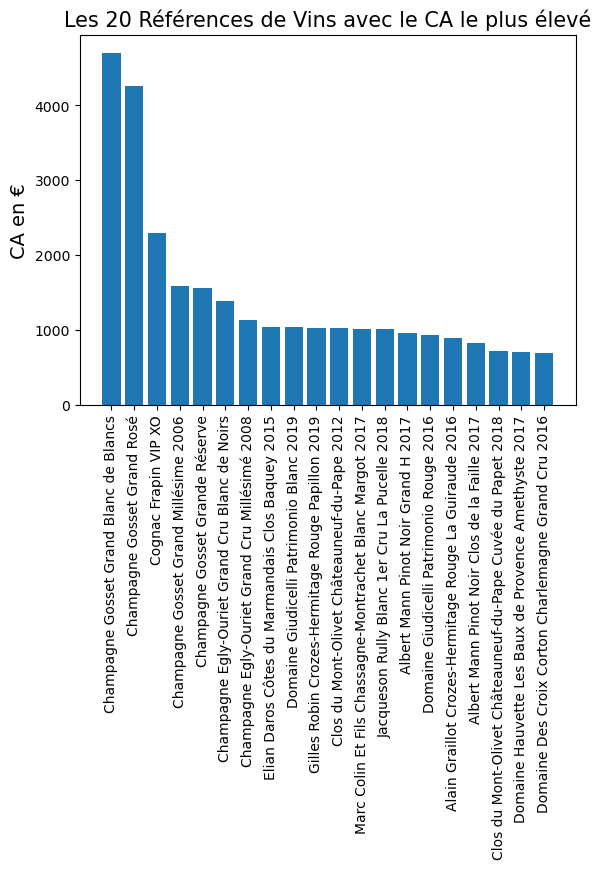

In [38]:
plt.bar(CA_top['post_title'], CA_top['CA'])
plt.ylabel('CA en €', fontsize=14)
plt.xticks(rotation = '90')
plt.title('Les 20 Références de Vins avec le CA le plus élevé',fontsize=15)
plt.show()


##### Les 20 références de vins qui ont le CA le plus bas

In [39]:
CA_flop = erp_web[['product_id', 'sku','post_title', 'price','total_sales','CA']].sort_values(by = 'CA', ascending = True).head(20)
CA_flop

,product_id,sku,post_title,price,total_sales,CA
824,7338,16230,Domaine Saint-Nicolas Vin de France Blanc Les ...,16.3,0.0,0.0
365,4759,16229,Domaine Saint-Nicolas Fiefs Vendéens Rouge Ref...,16.9,0.0,0.0
364,4758,15859,Domaine Saint-Nicolas Fiefs Vendéens Rouge Cuv...,24.3,0.0,0.0
668,5962,16326,Camin Larredya Jurançon Moelleux Au Capcéu 2018,30.0,0.0,0.0
362,4755,16132,Domaine de Montgilet Vin de France Grolleau 2019,7.4,0.0,0.0
360,4752,14184,Domaine de Montgilet Coteaux de l'Aubance Les ...,27.9,0.0,0.0
358,4749,15315,Domaine de Montgilet Anjou Blanc 2016,11.9,0.0,0.0
357,4748,14632,Jean-Paul Brun Saint-Amour 2017,14.5,0.0,0.0
354,4740,13412,Jean-Paul Brun Beaujolais L'Ancien 2016,9.7,0.0,0.0
353,4739,14366,Jean-Paul Brun Beaujolais Le Ronsay 2016,7.4,0.0,0.0


Nous obtenons une liste partielle d'invendus.

Nous allons chercher à connaître la liste totale des références de vins invendues.

In [40]:
invendus = erp_web[ erp_web['total_sales'] == 0.0 ]
nombre_invendus = invendus['product_id'].count()
nombre_references_total = erp_web['product_id'].count()
print(nombre_invendus, "références de vins n'ont jamais été vendues", round(nombre_invendus/nombre_references_total*100,2), "% des références de vins .")


329 références de vins n'ont jamais été vendues 44.82 % des références de vins .


### 2.2 Chiffre d’affaires total <a class="anchor" id="##section_2_2"></a>

In [41]:
CA = erp_web['CA'].sum()
print("Le Chiffre d'affaires total s'élève à",CA, "€")

Le Chiffre d'affaires total s'élève à 70568.6 €


##### Quelle part du CA total représente les 20 Vins les plus rentables?

In [42]:
CA_total_top20 = CA_top['CA'].sum()
proportion_CA_total_top20 = round(CA_total_top20 / CA * 100,2)
print("Le CA total des 20 vins les plus bénéfiques est de",CA_total_top20 ,"€")
print(round(20/825*100,2), "% des références de vins rapportent",proportion_CA_total_top20, "% du CA total.")

Le CA total des 20 vins les plus bénéfiques est de 28768.0 €
2.42 % des références de vins rapportent 40.77 % du CA total.


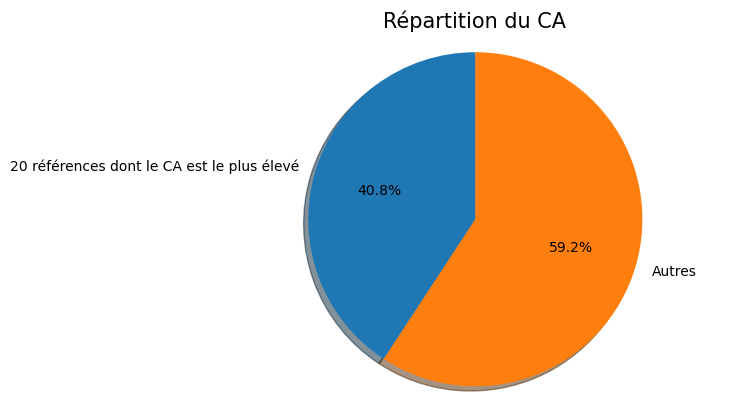

In [43]:
name = ['20 références dont le CA est le plus élevé', 'Autres']
data = [CA_total_top20, CA-CA_total_top20]

explode=(0, 0)
plt.pie(data,explode=explode, labels=name, autopct='%1.1f%%', startangle=90, shadow=True)
plt.axis('equal')
plt.title('Répartition du CA',fontsize=15)
plt.show()

## 3 Recherche des valeurs extrêmes 'price' <a class="anchor" id="#chapter3"></a>

###  3.1 Méthode de l' écart interquartile <a class="anchor" id="##section_3_1"></a>

Nous allons visualiser la répartition de la variable 'price' ainsi que les valeurs extrêmes à l'aide d'un box-plot.

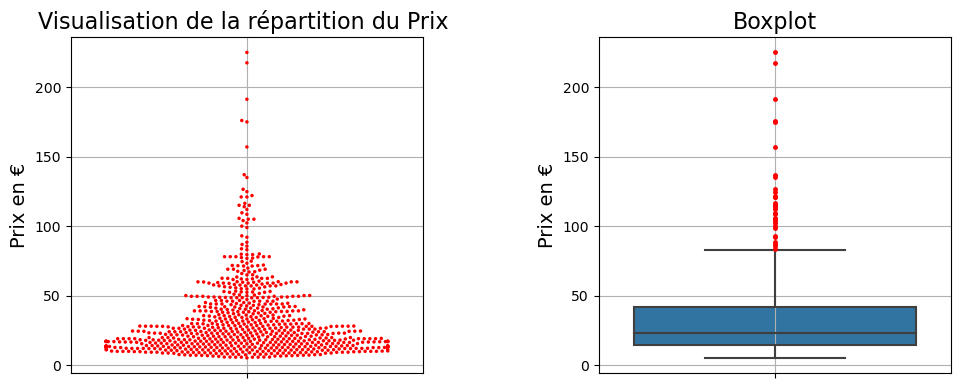

In [44]:
#On affiche une visualisation de la répartition des prix avec un swarmplot et le boxplot associé à la variable 'price'

plt.subplot(1, 2, 1)

sns.swarmplot(y=erp_web['price'],marker='o', size=2.5, color="red")
plt.grid()
plt.ylabel('Prix en €', fontsize= 14)
plt.title('Visualisation de la répartition du Prix ', fontsize= 16)

#le boxplot associé à la variable 'price'

plt.subplot(1, 2, 2)

flierprops = dict(marker='o', markersize=2.5, markeredgecolor='red', markerfacecolor='red', alpha=1)
sns.boxplot(y=erp_web['price'],flierprops=flierprops )
plt.grid()
plt.ylabel('Prix en €', fontsize= 14)
plt.title('Boxplot', fontsize= 16)
plt.savefig('boxplot.png')
         
# space between the plots

plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0)

Chiffrons maintenant ces données visualisées avec le calcul de l'écart interquartile.


Q1 et Q3 sont respectivement le premier quartile et le troisième quartile.

On définit une donnée aberrante comme étant toute valeur située à l'extérieur de l'intervalle: [ Q1-1.5*IQR , Q3+1.5*IQR ]
avec IQR l'écart interquartile définit comme IQR=Q3-Q1.


In [45]:
# On calcule la valeur médiane
mediane = np.median(erp_web['price'])
mediane

23.4

In [46]:
# On calcule Q1 
Q1=erp_web['price'].quantile(q=0.25)
Q1

14.1

In [47]:
# On calcule Q3
Q3=erp_web['price'].quantile(q=0.75)
Q3

41.8

In [48]:
# On calcule l'écart interquartile (IQR)
IQR=Q3-Q1
round(IQR,2)

27.7

In [49]:
# On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile
borne_inf = Q1-1.5*IQR
round(borne_inf,2)

-27.45

In [50]:
# On recherche la valeur de prix minimale
minimum = np.min(erp_web['price'])
minimum

5.2

In [51]:
# On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile
borne_sup = Q3+1.5*IQR
borne_sup

83.35

In [52]:
# Outliers 
outliers_sup = erp_web[erp_web['price']>borne_sup]
outliers_inf =erp_web[erp_web['price']<borne_inf]

In [53]:
outliers_inf['product_id'].count()

0

Nous n'avons aucune valeur extrême basse. 

Regardons maintenant les valeurs extrêmes supérieures.

In [54]:
outliers_sup[['product_id', 'sku','post_title', 'price','total_sales','CA']].sort_values(by = 'price', ascending = False)

,product_id,sku,post_title,price,total_sales,CA
208,4352,15940,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,5.0,1125.0
460,5001,14581,David Duband Charmes-Chambertin Grand Cru 2014,217.5,0.0,0.0
635,5892,14983,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3,3.0,573.9
227,4402,3510,Cognac Frapin VIP XO,176.0,13.0,2288.0
598,5767,15185,Camille Giroud Clos de Vougeot 2016,175.0,0.0,0.0
230,4406,7819,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0,0.0,0.0
411,4904,14220,Domaine Des Croix Corton Charlemagne Grand Cru...,137.0,5.0,685.0
697,6126,14923,Champagne Gosset Célébris Vintage 2007,135.0,2.0,270.0
210,4355,12589,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,11.0,1391.5
556,5612,14915,Domaine Weinbach Gewurztraminer Grand Cru Furs...,124.8,0.0,0.0


In [55]:
outliers_sup['product_id'].count()

33

Il y a 33 valeurs extrêmes supérieures.

In [56]:
# Exportation des données en fichier excel 
outliers_sup.to_excel('projet5_outliers_sup.xlsx', sheet_name='outliers', index=False)

### 3.2  Méthode du z-score <a class="anchor" id="##section_3_2"></a>

Nous allons rechercher les valeurs aberrantes à l'aide d'une autre méthode, la méthode du z-score.

En supposant une distribution normale de données, le score Z indique de combien d'écarts-types σ la valeur de X est éloignée de la moyenne μ.
Il est calculé selon la formule:  Z = (X−μ) / σ

95% environ des observations sont comprises dans un intervalle de +/- 2 fois l'écart-type autour de la moyenne.
Toute valeur qui se trouve en dehors de cette plage est considérée comme une anomalie.



Pour des échantillons supérieurs à 30 (825 dans notre cas), la loi normale est en général une bonne approximation de la distribution réelle (voir théorème central limite).



##### Calcul du z_score

In [57]:
erp_web['z_scores']=stats.zscore(erp_web['price'])
erp_web[['product_id', 'sku','post_title', 'price','total_sales','CA','z_scores']]

,product_id,sku,post_title,price,total_sales,CA,z_scores
0,3847,15298,Pierre Jean Villa Saint-Joseph Préface 2018,24.2,6.0,145.2,-0.291452
1,3849,15296,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,34.3,0.0,0.0,0.075731
2,3850,15300,Pierre Jean Villa Crozes-Hermitage Accroche Co...,20.8,0.0,0.0,-0.415059
3,4032,19814,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,14.1,3.0,42.3,-0.658636
4,4039,19815,Pierre Jean Villa Côte Rôtie Carmina 2017,46.0,0.0,0.0,0.501082
...,...,...,...,...,...,...,...
792,7023,15891,Camin Larredya Jurançon Sec La Virada 2018,27.5,0.0,0.0,-0.171482
793,7025,15887,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,69.0,0.0,0.0,1.337242
822,7247,13127-1,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,54.8,0.0,0.0,0.821004
823,7329,14680-1,NaN,26.5,NaN,NaN,-0.207836


In [58]:
# Exportation des données en fichier excel 
erp_web.to_excel('projet5_erp_web.xlsx', sheet_name='sheet1', index=False)

##### Visualisation des ouliers à l'aide des z_scores

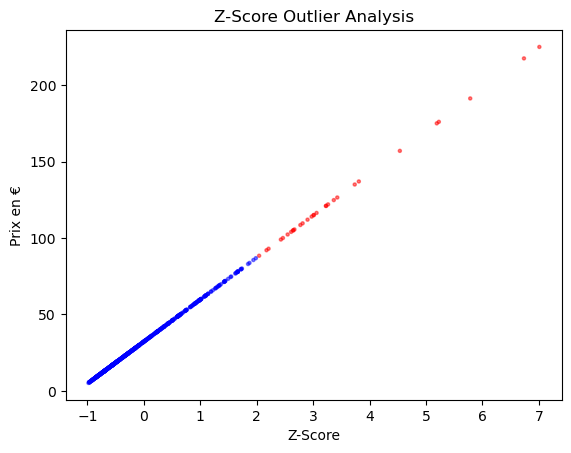

In [59]:
z_scores = erp_web['z_scores']
prix = erp_web['price']

# Plot the Z-scores
plt.scatter(z_scores,prix, s=5, c=[("red" if abs(z) > 2 else "blue") for z in z_scores], alpha=0.5)

plt.title("Z-Score Outlier Analysis")
plt.xlabel("Z-Score")
plt.ylabel("Prix en €")

plt.savefig('z_scores.png')
plt.show()

Nous observons que nous n'avons pas de z-score < -2 et qu'il y a des valeurs z-score >2.

##### Tableau répertoriant les outliers

In [60]:
price_outlier = erp_web.loc [(erp_web['z_scores']<-2) | (erp_web['z_scores']>2) ]
price_outlier.sort_values(by = 'z_scores', ascending = False)
price_outlier[['product_id', 'sku','post_title', 'price','total_sales','CA','z_scores']].sort_values(by = 'price', ascending = False)

,product_id,sku,post_title,price,total_sales,CA,z_scores
208,4352,15940,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,5.0,1125.0,7.008589
460,5001,14581,David Duband Charmes-Chambertin Grand Cru 2014,217.5,0.0,0.0,6.735928
635,5892,14983,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3,3.0,573.9,5.783433
227,4402,3510,Cognac Frapin VIP XO,176.0,13.0,2288.0,5.227205
598,5767,15185,Camille Giroud Clos de Vougeot 2016,175.0,0.0,0.0,5.190850
230,4406,7819,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0,0.0,0.0,4.536464
411,4904,14220,Domaine Des Croix Corton Charlemagne Grand Cru...,137.0,5.0,685.0,3.809368
697,6126,14923,Champagne Gosset Célébris Vintage 2007,135.0,2.0,270.0,3.736658
210,4355,12589,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,11.0,1391.5,3.427643
556,5612,14915,Domaine Weinbach Gewurztraminer Grand Cru Furs...,124.8,0.0,0.0,3.365839


In [61]:
len(price_outlier)

30

Cette méthode nous donne une liste de 30 valeurs aberrantes de prix. 


#### 3.3 Comparaison des 2 méthodes <a class="anchor" id="##section_3_3"></a>

Nous allons joindre les 2 tableaux d'outliers.

In [62]:
outliers = pd.merge(outliers_sup, price_outlier, how='left')
outliers[['product_id', 'sku','post_title', 'price','total_sales','CA','z_scores']].sort_values(by = 'price', ascending = False)

,product_id,sku,post_title,price,total_sales,CA,z_scores
2,4352,15940,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,5.0,1125.0,7.008589
12,5001,14581,David Duband Charmes-Chambertin Grand Cru 2014,217.5,0.0,0.0,6.735928
21,5892,14983,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3,3.0,573.9,5.783433
5,4402,3510,Cognac Frapin VIP XO,176.0,13.0,2288.0,5.227205
20,5767,15185,Camille Giroud Clos de Vougeot 2016,175.0,0.0,0.0,5.190850
7,4406,7819,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0,0.0,0.0,4.536464
11,4904,14220,Domaine Des Croix Corton Charlemagne Grand Cru...,137.0,5.0,685.0,3.809368
25,6126,14923,Champagne Gosset Célébris Vintage 2007,135.0,2.0,270.0,3.736658
3,4355,12589,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,11.0,1391.5,3.427643
19,5612,14915,Domaine Weinbach Gewurztraminer Grand Cru Furs...,124.8,0.0,0.0,3.365839


Les 30 valeurs trouvées avec la méthode z-score sont cohérentes avec les 33 trouvées avec la méthode de l'écart interquartile. 

Les 3 valeurs de différences sont liées au fait que les seuils de prix établis pour définir une valeur aberrante ne sont pas les mêmes entre les 2 méthodes.

Le vin le moins cher de la méthode z-score est de 88.40€ contre 83.70€ pour la méthode de l'interquartile.

#### 3.4 Vérification des valeurs extrêmes <a class="anchor" id="##section_3_4"></a>

Nous comparons les prix de vente des vins dont les valeurs sont extrêmes avec les valeurs en ligne chez la concurrence.

Ces prix sont cohérents et ne semblent donc pas être des valeurs erronnées.


##### Quelle part du chiffre d'affaires représente ces valeurs extrêmes?

In [63]:
CA_outliers_nul = outliers[outliers['CA']== 0.0]
nombre_invendus_outliers = CA_outliers_nul['product_id'].count()
nombre_invendus_outliers

23

In [64]:
CA_outliers = outliers['CA'].sum()
proportion_CA_outliers = round(outliers['CA'].sum() / CA * 100,2)
print("Le CA total des valeurs extrêmes est de",CA_outliers ,"€, ce qui correspond à",proportion_CA_outliers, "% du CA total.")

Le CA total des valeurs extrêmes est de 6970.0 €, ce qui correspond à 9.88 % du CA total.
